<a href="https://colab.research.google.com/github/Crinmatic/Word-level-Optical-Recognition-on-Yoruba-language/blob/main/Handwritten_word_Character_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U tensorflow-addons
import cv2
import os
import imutils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import random
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import Input, Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from keras.models import Sequential, load_model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.9 MB/s 


In [ ]:
dir = "/content/drive/MyDrive/Datasets/word level  yoruba handwritten TRAINING DATASET/Letters_Data"
train_data = []
img_size = 32
non_chars = ["#","$","&","@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 4000:
            break
        img = cv2.imread(os.path.join(sub_directory,j), 0)
        img = cv2.resize(img,(img_size,img_size))
        thresh = cv2.threshold(img, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        blurred = cv2.GaussianBlur(thresh, (5, 5), 0)
        train_data.append([blurred,i])

In [ ]:
len(train_data)

8820

In [ ]:
train_data

[[array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'D'],
 [array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'D'],
 [array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'D'],
 [array([[ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         ...,
         [ 0,  4, 26, ...,  0,  0,  0],
         [ 0,  7, 39, ...,  0,  0,  0],
         [ 0,  8, 42, ...,  0,  0,  0]], dtype=uint8), 'D'],
 [array(

In [ ]:
random.shuffle(train_data)

In [ ]:
X_train = []
y_train = []
for features,label in train_data:
    X_train.append(features)
    y_train.append(label)

In [ ]:
LB = LabelBinarizer()
y_train = LB.fit_transform(y_train)


In [ ]:
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
X_train = np.asarray(X_train)/255.0
X_train = X_train.reshape(-1,32,32,1)

y_train = np.array(y_train)

In [ ]:
X_train.shape

(8820, 32, 32, 1)

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 20
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
num_classes = 60
input_shape = (32, 32, 1)


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size)
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]

plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
     # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
inputs = layers.Input(shape=input_shape)
    # Augment data.
augmented = data_augmentation(inputs)
    # Create patches.
patches = Patches(patch_size)(augmented)
    # Encode patches.
encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
representation = layers.Flatten()(representation)
representation = layers.Dropout(0.5)(representation)
    # Add MLP.
features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
model = keras.Model(inputs=inputs, outputs=logits)
   

In [ ]:

optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

checkpoint_filepath = "/content/drive/MyDrive/Datasets/word level  yoruba handwritten TRAINING DATASET/tmp/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

history = model.fit(
        x= X_train,
        y= y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.2,
        callbacks=[checkpoint_callback],
    )
    
    





Epoch 1/20
28/28 [==============================] - 447s 15s/step - loss: 4.4457 - accuracy: 0.0565 - top-5-accuracy: 0.2014 - val_loss: 3.2607 - val_accuracy: 0.2319 - val_top-5-accuracy: 0.5278
Epoch 2/20
28/28 [==============================] - 438s 16s/step - loss: 3.2061 - accuracy: 0.1908 - top-5-accuracy: 0.4887 - val_loss: 2.4565 - val_accuracy: 0.3719 - val_top-5-accuracy: 0.7171
Epoch 3/20
28/28 [==============================] - 438s 16s/step - loss: 2.7400 - accuracy: 0.2785 - top-5-accuracy: 0.6213 - val_loss: 2.1416 - val_accuracy: 0.4286 - val_top-5-accuracy: 0.7664
Epoch 4/20
28/28 [==============================] - 441s 16s/step - loss: 2.4130 - accuracy: 0.3468 - top-5-accuracy: 0.7031 - val_loss: 1.9110 - val_accuracy: 0.4637 - val_top-5-accuracy: 0.8141
Epoch 5/20
28/28 [==============================] - 432s 15s/step - loss: 2.1888 - accuracy: 0.3845 - top-5-accuracy: 0.7557 - val_loss: 1.7442 - val_accuracy: 0.4892 - val_top-5-accuracy: 0.8424
Epoch 6/20
28/28 [==

In [ ]:
checkpoint_filepath = "/content/drive/MyDrive/Datasets/word level  yoruba handwritten TRAINING DATASET/tmp/checkpoint"

In [ ]:
model.load_weights(checkpoint_filepath)
_, accuracy, top_5_accuracy = model.evaluate(train_X, train_Y)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
c = model.predict(train_X)
print("result:", c)
pred = LB.inverse_transform(c)
print(pred)

In [ ]:
model.summary()

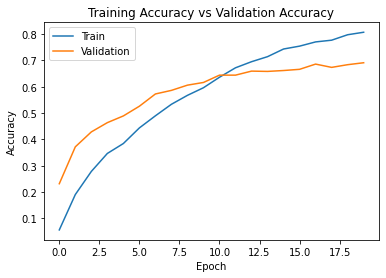

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

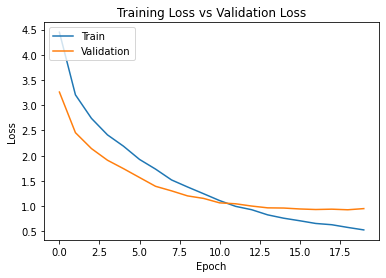

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
te = cv2.imread("/content/drive/MyDrive/Datasets/falade test/Abà/Abà.jpg",0)
te = cv2.resize(te,(32,32))
thresh = cv2.threshold(te, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
dilated = cv2.dilate(thresh, None, iterations=2)
blurred = cv2.GaussianBlur(dilated, (5, 5), 0)
input_image = np.expand_dims(blurred, axis=0)
input_image.shape
#te = te.reshape(-1,32,32,3)

(1, 32, 32)

In [ ]:
predic = model.predict(input_image)

In [ ]:
ypr = LB.inverse_transform(predic)
ypr

array(['N'], dtype='<U3')

In [ ]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)


In [ ]:
def get_letters(img):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    blurred = cv2.GaussianBlur(thresh, (5, 5), 0)
    cnts = cv2.findContours(blurred.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1,32,32,1)
        ypred = model.predict(thresh)
        ypred = LB.inverse_transform(ypred)
        [x] = ypred
        letters.append(x)
    return letters, image

#plt.imshow(image)

In [ ]:
def get_word(letter):
    words = "".join(letter)
    return words

ÚhUn


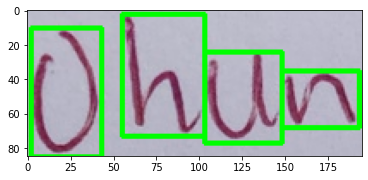

In [ ]:
letter,image = get_letters("/content/drive/MyDrive/Datasets/falade train/Ohun/Ohun4.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)
